In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

pd.options.mode.chained_assignment = None

In [2]:
col_names = [f'A{i}' for i in range(1, 17)]
df = pd.read_csv('crx.data', names=col_names, header=0)

In [24]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
1,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
2,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
3,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
4,b,32.08,4.000,u,g,m,v,2.50,t,f,0,t,g,00360,0,+


In [51]:
def preprocess(df):
    df = df.replace('?', np.NaN)
    df = df.replace({'A1': {'a': 1, 'b': 0}, 'A9': {'t': 1, 'f': 0}, 'A10': {'t': 1, 'f': 0}, 'A12': {'t': 1, 'f': 0}, 'A16': {'+': 1, '-': 0}})
    df = df.astype({'A1': 'boolean', 'A2': 'float64', 'A3': 'float64', 'A8': 'float64', 'A9': 'boolean', 'A10': 'boolean', 'A11': 'Int64', 'A12': 'boolean', 'A14': 'Int64', 'A15': 'Int64', 'A16': 'boolean'})
    return df

In [26]:
df = preprocess(df)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      677 non-null    boolean
 1   A2      677 non-null    float64
 2   A3      689 non-null    float64
 3   A4      683 non-null    object 
 4   A5      683 non-null    object 
 5   A6      680 non-null    object 
 6   A7      680 non-null    object 
 7   A8      689 non-null    float64
 8   A9      689 non-null    boolean
 9   A10     689 non-null    boolean
 10  A11     689 non-null    Int64  
 11  A12     689 non-null    boolean
 12  A13     689 non-null    object 
 13  A14     676 non-null    Int64  
 14  A15     689 non-null    Int64  
 15  A16     689 non-null    boolean
dtypes: Int64(3), boolean(5), float64(3), object(5)
memory usage: 68.1+ KB


In [28]:
df.isnull().sum()

A1     12
A2     12
A3      0
A4      6
A5      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14    13
A15     0
A16     0
dtype: int64

In [29]:
df.isnull().any(axis=1).sum()

37

dane z nullami można wydropić bo jest ich mniej niż 5%, ale uzupełnimy medianą (numeryczne) i modą (kategoryczne), bo to nadal dośc mały zbiór danych

In [24]:
def handle_nulls(train, test):
    imputer_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    numerical = ['A1', 'A2', 'A3', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15']
    train_num = train.loc[:, numerical]
    train[numerical] = imputer_mean.fit_transform(train_num)
    test_num = test.loc[:, numerical]
    test[numerical] = imputer_mean.transform(test_num)

    imputer_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    categorical = ['A4', 'A5', 'A6', 'A7', 'A13']
    train_categorical = train.loc[:, categorical]
    test_categorical = test.loc[:, categorical]
    train[categorical] = imputer_mode.fit_transform(train_categorical)
    test[categorical] = imputer_mode.transform(test_categorical)

    return train, test

In [5]:
def one_hot_encoding(train, test):
  to_encode = ['A4', 'A5', 'A6', 'A7', 'A13']

  train_cat = train[to_encode]
  test_cat = test[to_encode]

  joined = pd.concat([train_cat, test_cat])

  for column in to_encode:
    train_dummies = pd.get_dummies(train[[column]], prefix=column)
    train = pd.concat([train, train_dummies], axis=1)
    train = train.drop([column], axis=1)

    test_dummies = pd.get_dummies(test[[column]], prefix=column)
    test = pd.concat([test, test_dummies], axis=1)
    test = test.drop([column], axis=1)
  
  cols = train.columns.union(test.columns)
  train = train.reindex(cols, axis=1, fill_value=0)
  test = test.reindex(cols, axis=1, fill_value=0)

  return train, test

TypeError: ignored

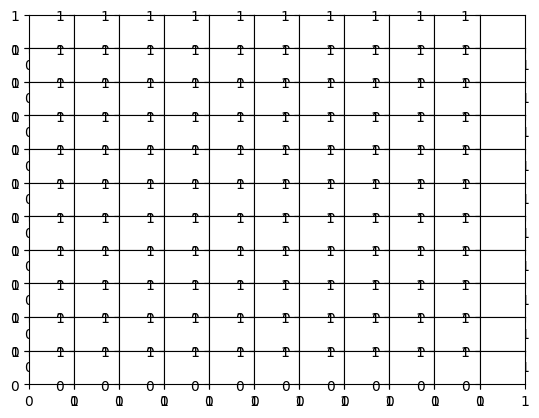

In [32]:
# scatter_matrix(df)

In [44]:
def normalize(train, test):
#     to_norm_std = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
    scaler = MinMaxScaler()
    train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), columns=test.columns)
    return train, test

In [36]:
df['A16'].value_counts()

False    383
True     306
Name: A16, dtype: Int64

Zbiór jest zbalansowany więc accuracy będzie odpowiednią metryką


In [60]:
def cross_validation(model, df):
    df = preprocess(df)
    ss = ShuffleSplit(5, test_size=0.3, random_state=2)
    scores = []
    y = df['A16']
    X = df.drop(columns=['A16'])

    for train, test in ss.split(X, y):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        X_train, X_test = handle_nulls(X_train, X_test)
        assert X_train.isnull().any(axis=1).sum() + X_test.isnull().any(axis=1).sum() == 0
        X_train, X_test = one_hot_encoding(X_train, X_test)
        X_train, X_test = normalize(X_train, X_test)
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
    
    return scores

In [61]:
df = pd.read_csv('crx.data', names=col_names, header=0)
rf = RandomForestClassifier()

scores = cross_validation(rf, df)
print(scores)
print(np.average(scores))

[0.8792270531400966, 0.8647342995169082, 0.8309178743961353, 0.8985507246376812, 0.8599033816425121]
0.8666666666666666


In [62]:
df = pd.read_csv('crx.data', names=col_names, header=0)
knn = KNeighborsClassifier()

scores = cross_validation(knn, df)
print(scores)
print(np.average(scores))

[0.8647342995169082, 0.821256038647343, 0.8019323671497585, 0.8743961352657005, 0.8309178743961353]
0.8386473429951691


In [63]:
df = pd.read_csv('crx.data', names=col_names, header=0)
clf = GaussianNB()

scores = cross_validation(clf, df)
print(scores)
print(np.average(scores))

[0.6666666666666666, 0.7584541062801933, 0.6908212560386473, 0.642512077294686, 0.5942028985507246]
0.6705314009661836


In [64]:
df = pd.read_csv('crx.data', names=col_names, header=0)
clf = SVC()

scores = cross_validation(clf, df)
print(scores)
print(np.average(scores))

[0.8792270531400966, 0.8454106280193237, 0.8260869565217391, 0.8695652173913043, 0.8454106280193237]
0.8531400966183575


Dla bazowych parametrów najlepiej sprawdzają się lasy losowe a najgorzej Naiwny Bayes